In [122]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from collections import defaultdict
import tensorflow as tf
import os

In [123]:
import json
from sklearn.preprocessing import OneHotEncoder
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer as NBA
from textblob.tokenizers import SentenceTokenizer as ST
from wordcloud import WordCloud, STOPWORDS
import string

In [124]:
#Data obtained from https://github.com/bpb27/trump_tweet_data_archive

In [125]:
def vectorize_letters(tweets):
    all_characters = ["{}".format(_) for tweet in tweets for _ in tweet]
    print("There are {} characters.".format(len(all_characters)))
    char_to_index = {u: i for i, u in enumerate(sorted(set(all_characters)))}

    vectorized = [[char_to_index[_] for _ in tweet] for tweet in tweets]
    return vectorized, char_to_index


In [126]:
def check_if_website(text):
    #Check for website:
    if text[:6] == "https:":
        website = True
    else:
        website = False
    return website


def remove_at_symbol(word):
    if word[0] == '@':
        return word[1:]
    else:
        return word


def separate_and_remove_special(text):
    text = "".join(
        [char for char in text if char not in ['“', '”', '(', ')'] and ord(char) < 128])
    #remove twitter's quotation characters.
    text_list = text.split(" ")
    #split the text into words to clean each word
    clean_string = []
    for word in text_list:
        if len(word) > 0:
            word = remove_at_symbol(word)
            website = check_if_website(word)
            if not website:
                clean_string.append(word)
    return " ".join(clean_string)


def parse_text(tweet):
    """
    Parse the message and only save it if it fits 
    the criteria:
        Not just a website link
    """
    website = check_if_website(tweet["text"])
    retweet = tweet["is_retweet"]
    #Remove the Retweet header if present
    if not website and not retweet:
        clean_string = separate_and_remove_special(tweet["text"])
        return clean_string
    else:
        return None

In [127]:
with open('condensed_2018.json') as f:
    tweets = json.load(f)
    print("There are {} tweets to parse.".format(len(tweets)))

There are 3510 tweets to parse.


In [128]:
clean_tweets = []
total_tweets = len(tweets)
for tweet in tweets:
    clean = parse_text(tweet)
    if clean != None:
        clean_tweets.append(clean)
print("There are {} usable tweets after removing {} \"bad\" tweets.".format(
    len(clean_tweets), total_tweets - len(clean_tweets)))

There are 2991 usable tweets after removing 519 "bad" tweets.


In [129]:
sentiment_list = []
nouns_list = []
verbs_list = []
adjectives_list = []
for clean in clean_tweets:
    tweet = TextBlob(clean, tokenizer=ST())
    for sub_tweet in tweet.tokens:
        sent = TextBlob(sub_tweet)
        for tag in sent.tags:
            if tag[1] in ["NN", "NNS", "NNP", "NNPS"]:
                nouns_list.append(tag[0])
                #nouns_list.append(tag[0].singularize())
        if not np.isclose(0.0, sent.sentiment[0]):
            sentiment_list.append([sent.sentiment[0], sent.sentiment[1]])
    #tweet = TextBlob(clean_tweets[i], analyzer=NaiveBayesAnalyzer())

In [130]:
sentiment_list = np.array(sentiment_list)

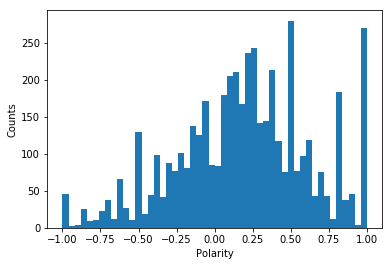

In [131]:
fig, ax = plt.subplots()
hist = ax.hist(sentiment_list[:, 0], bins=50)
txt = ax.set_xlabel("Polarity")
txt = ax.set_ylabel("Counts")
#hist = ax.hist(sentiment_list[:,1], bins = 30, alpha = 0.5)

In [132]:
def generate_cloud_mask():
    trump_mask = np.array(Image.open("trump_mask.png"))
    trump_mask[trump_mask >= 1] = 255
    trump_mask[trump_mask < 1] = 0.
    trump_mask = trump_mask * -1
    trump_mask = trump_mask + 255
    return trump_mask

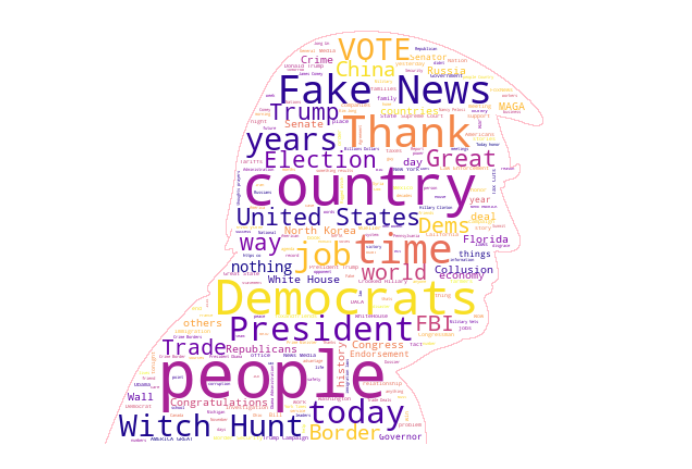

In [133]:
trump_mask = generate_cloud_mask()
ratio = trump_mask
mask_ratio = trump_mask.shape[1]/trump_mask.shape[0]
stopwords = set(STOPWORDS)
stopwords.add("amp")
wc = WordCloud(
    background_color="white",
    max_words=1000,
    mask=trump_mask,
    stopwords=stopwords,
    contour_width=0.01,
    contour_color="pink",
    colormap='plasma',
    #colormap = 'RdBu',
    normalize_plurals=False,
)
wc.generate(" ".join(nouns_list))
figsize = 8
fig, ax = plt.subplots(figsize=(figsize*mask_ratio, figsize))
ax.imshow(wc, interpolation='bilinear')
p = plt.axis("off")
plt.savefig("trump.png", bbox_inches="tight")

In [134]:
def check_start(sentence_start):
    capitalized = sentence_start[0].isupper()
    non_punctuation = sentence_start[-1] not in string.punctuation
    if capitalized and non_punctuation:
        return True
    else:
        return False
class Markov_Text_Prediction:
    def __init__(self, tweets):
        self.tweets = tweets
        
    def run(self):
        self.tweet_combiner()
        self.generate_dict()
        pairs = self.make_pairs()
        for w1, w2, in pairs:
            if w1 in self.word_dict.keys():
                self.word_dict[w1].append(w2)
            else:
                self.word_dict[w1] = [w2]
        
    def tweet_combiner(self):
        self.corpus = " ".join(self.tweets).split()
        
    def make_pairs(self):
        for i in range(1, len(self.corpus)-1):
            yield (self.corpus[i], self.corpus[i+1])
        
    def generate_dict(self):
        s = [(self.corpus[0], [self.corpus[1]])]
        self.word_dict = defaultdict(list)
        for k, v in s:
            self.word_dict[k].append(v)
            
        
    def get_next_word(self, tweet, tolerance, min_occurances):
        iterations = 0
        keep = False
        while not keep:
            proposed_word = np.random.choice(self.word_dict[tweet[-1]])
            possibilities = len(self.word_dict[tweet[-1]])
            occurances = self.word_dict[tweet[-1]].count(proposed_word)
            if occurances/possibilities > tolerance or occurances > min_occurances:
                keep = True
            iterations += 1
            if iterations > 100:
                break
        return proposed_word
        
    def predict(self, max_words = 30, tolerance = 0.05, min_occurances=10):
        counter = 0
        sentence_start = np.random.choice(self.corpus)
        while check_start(sentence_start) == False:
            sentence_start = np.random.choice(self.corpus)
            
        tweet = [sentence_start]
        for _ in range(1, max_words+100):
            tweet.append(self.get_next_word(tweet, tolerance, min_occurances))
            if tweet[-1][-1] in [".", "!", "?"]:
                frac = _/max_words
                if np.random.random() < frac:
                    break
        print(" ".join(tweet))

In [135]:
chain = Markov_Text_Prediction(clean_tweets)
chain.run()

In [136]:
chain.predict(tolerance = 0.05, min_occurances = 10)

If the Obama Administration has been a great honor to go on FoxNews The Democrats want to the United States, which was my honor to our great honor to stop the right to be interviewed by the World War with a great honor to get the Fake News Media is no longer a big time in the American people and they were not to the U.S.


The Markov Chain doesn't work super well. Let's try a recurrent neural network.

In [137]:
vectorized, char_to_index = vectorize_letters(clean_tweets)
index_to_char = {v: k for k, v in char_to_index.items()}
print(vectorized[0], "--->",
      "".join([index_to_char[_] for _ in vectorized[0]]))

There are 578100 characters.
[37, 30, 45, 45, 54, 1, 43, 34, 52, 1, 54, 34, 30, 47, 2] ---> HAPPY NEW YEAR!


In [209]:
print(char_to_index)

{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6, '&': 7, "'": 8, '*': 9, '+': 10, ',': 11, '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, ';': 26, '=': 27, '?': 28, '@': 29, 'A': 30, 'B': 31, 'C': 32, 'D': 33, 'E': 34, 'F': 35, 'G': 36, 'H': 37, 'I': 38, 'J': 39, 'K': 40, 'L': 41, 'M': 42, 'N': 43, 'O': 44, 'P': 45, 'Q': 46, 'R': 47, 'S': 48, 'T': 49, 'U': 50, 'V': 51, 'W': 52, 'X': 53, 'Y': 54, 'Z': 55, '_': 56, 'a': 57, 'b': 58, 'c': 59, 'd': 60, 'e': 61, 'f': 62, 'g': 63, 'h': 64, 'i': 65, 'j': 66, 'k': 67, 'l': 68, 'm': 69, 'n': 70, 'o': 71, 'p': 72, 'q': 73, 'r': 74, 's': 75, 't': 76, 'u': 77, 'v': 78, 'w': 79, 'x': 80, 'y': 81, 'z': 82, '|': 83}


In [257]:
class Neural_Net:
    def __init__(self, vectorized):
        self.vectorized = vectorized
        self.in_length = 30
        self.size = int(1e6)
        self.rnn_size = 128
        self.out_size = len(np.unique(self.vectorized))

    def make_array(self):
        vectorized = np.array([i for x in self.vectorized for i in x])
        self.vectorized = vectorized.flatten()

    def make_encoded(self, ys):
        enc = OneHotEncoder()
        enc.fit(ys.reshape(-1, 1))
        ys = enc.transform(ys.reshape(-1, 1)).toarray()
        return ys

    def get_data(self):
        if os.path.exists("inputs.npy") and os.path.exists("outputs.npy"):
            batch = np.load("inputs.npy")
            ys = np.load("outputs.npy")
        else:
            size = self.size
            array = self.vectorized
            batch = []
            ys = []
            starts = np.random.randint(len(array) - self.in_length, size=size)
            for start in starts:
                batch.append(array[start:start + self.in_length])
                y = array[(start + self.in_length + 1) % len(array)]
                ys.append(y)
            ys = np.array(ys)
            batch = np.array(batch)
            np.save("outputs.npy", ys)
            np.save("inputs.npy", batch)
        ys = self.make_encoded(ys)
        return batch, ys

    def run(self, epochs):
        inputs, outputs = self.get_data()
        X = np.reshape(inputs, (self.size, self.in_length, 1))
        print(X.shape)
        X = X / self.out_size

        self.model = tf.keras.models.Sequential()
        self.model.add(
            tf.keras.layers.LSTM(
                self.rnn_size,
                input_shape=(X.shape[1], X.shape[2]),
                return_sequences=True))
        self.model.add(tf.keras.layers.Dropout(rate=0.2))
        self.model.add(tf.keras.layers.LSTM(self.rnn_size))
        self.model.add(tf.keras.layers.Dropout(rate=0.2))
        self.model.add(
            tf.keras.layers.Dense(outputs.shape[1], activation="softmax"))
        self.model.compile(loss="categorical_crossentropy", optimizer="adam")

        self.model.fit(X, outputs, epochs=epochs, batch_size=10000)

    def make_prediction(self, tweets, char_to_index, index_to_char, tweet_length=140):
        #self.model.predict(x, verbose=0)
        corpus = [sentence for sentence in tweets]
        sentence = np.random.choice(corpus)
        while len(sentence) < self.in_length:
            sentence = np.random.choice(corpus)
        new_sentence = sentence[:self.in_length]
        for _ in range(tweet_length):
            print(new_sentence[_:_+self.in_length])
            x = np.array([
                np.array([
                    np.array([
                        char_to_index[i] for i in new_sentence[_:_+self.in_length]
                    ])
                ]).T
            ]) / self.out_size
            prediction = self.model.predict(x, verbose=0)
            index = np.argmax(prediction)
            new_sentence += index_to_char[index]
        print(new_sentence)


In [258]:
the_donald = Neural_Net(vectorized)
the_donald.make_array()
the_donald.run(10)

/home/shmevlet/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(1000000, 30, 1)
Epoch 1/10
1000000/1000000 [==============================] - 37s 37us/sample - loss: 3.3946
Epoch 2/10
1000000/1000000 [==============================] - 30s 30us/sample - loss: 3.2393
Epoch 3/10
1000000/1000000 [==============================] - 30s 30us/sample - loss: 3.2322
Epoch 4/10
1000000/1000000 [==============================] - 30s 30us/sample - loss: 3.2279
Epoch 5/10
1000000/1000000 [==============================] - 30s 30us/sample - loss: 3.2260
Epoch 6/10
1000000/1000000 [==============================] - 30s 30us/sample - loss: 3.2243
Epoch 7/10
1000000/1000000 [==============================] - 30s 30us/sample - loss: 3.2234
Epoch 8/10
1000000/1000000 [==============================] - 30s 30us/sample - loss: 3.2228
Epoch 9/10
1000000/1000000 [==============================] - 30s 30us/sample - loss: 3.2219
Epoch 10/10
1000000/1000000 [==============================] - 30s 30us/sample - loss: 3.2216


In [259]:
the_donald.make_prediction(clean_tweets, char_to_index, index_to_char, tweet_length=40)

On the ten-year anniversary of
n the ten-year anniversary of 
 the ten-year anniversary of  
the ten-year anniversary of   
he ten-year anniversary of    
e ten-year anniversary of     
 ten-year anniversary of      
ten-year anniversary of       
en-year anniversary of        
n-year anniversary of         
-year anniversary of          
year anniversary of           
ear anniversary of            
ar anniversary of             
r anniversary of              
 anniversary of               
anniversary of                
nniversary of                 
niversary of                  
iversary of                   
versary of                    
ersary of                     
rsary of                      
sary of                       
ary of                        
ry of                         
y of                          
 of                           
of                            
f                             
                              
                              
        